In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold, LeaveOneGroupOut, StratifiedKFold
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import statsmodels.formula.api as smf
from tqdm import tqdm
import itertools
from sklearn.preprocessing import StandardScaler
import pickle

In [2]:
inDIR = '../data/training/'
inFILE = 'vor_2013_2022_cln_2023_08_29_plot_hls_idxs.csv'

inPATH = os.path.join(inDIR, inFILE)

lr_mod = pickle.load(open("../models/biomass/CPER_HLS_to_VOR_biomass_model_lr_simp.pk", 'rb'))

outDIR = './results/'

var_names = ['dfi', 'ndvi', 'ndti', 'satvi', 'ndii7', 
             'blue', 'green', 'red', 'nir', 'swir1', 'swir2',
             'bai_126', 'bai_136', 'bai_146', 'bai_236', 'bai_246', 'bai_346']

var_dict = {
    'NDVI': 'ndvi',
    'DFI': 'dfi',
    'NDTI': 'ndti',
    'SATVI': 'satvi',
    'NDII7': 'ndii7',
    'BAI_126': 'bai_126',
    'BAI_136': 'bai_136',
    'BAI_146': 'bai_146',
    'BAI_236': 'bai_236',
    'BAI_246': 'bai_246',
    'BAI_346': 'bai_346',
    'BLUE': 'blue',
    'GREEN': 'green',
    'RED': 'red',
    'NIR1': 'nir',
    'SWIR1': 'swir1',
    'SWIR2': 'swir2'
}

xv_vars = ['dfi', 'ndti', 'satvi', 'ndii7', 'swir1', 'swir2']
nsplits = 10

rand_st = 2313

In [3]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def vip(x, y, model):
    t = model.x_scores_
    #w = model.x_weights_
    w = model.x_rotations_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

In [4]:
df_results = pd.read_csv(os.path.join(outDIR, "VOR_lreg_results.csv"))
df_results_full = pd.read_csv(os.path.join(outDIR, "VOR_lreg_results_full.csv"))

In [5]:
df_vor = pd.read_csv(inPATH, parse_dates=[2, 3])
df_vor = df_vor.rename(columns=var_dict)

In [6]:
df_vor = df_vor[df_vor['Season'].isin(['June', 'October'])].copy()
#df_vor = df_vor[df_vor['Year'] >= 2017].copy()

In [7]:
# check for any missing data
len(df_vor[df_vor[var_names].isnull().any(axis=1)])

0

In [8]:
# remove missing data
df_vor = df_vor[~df_vor[var_names].isnull().any(axis=1)].copy()
#df_vor = df_vor[~df_vor['Id'].isin(df_vor[df_vor[var_names].isnull().any(axis=1)]['Id'].unique())].copy()

In [9]:
X_vars_all = df_vor[var_names]
Y_var_all = df_vor['Biomass_kg_ha']

<AxesSubplot:>

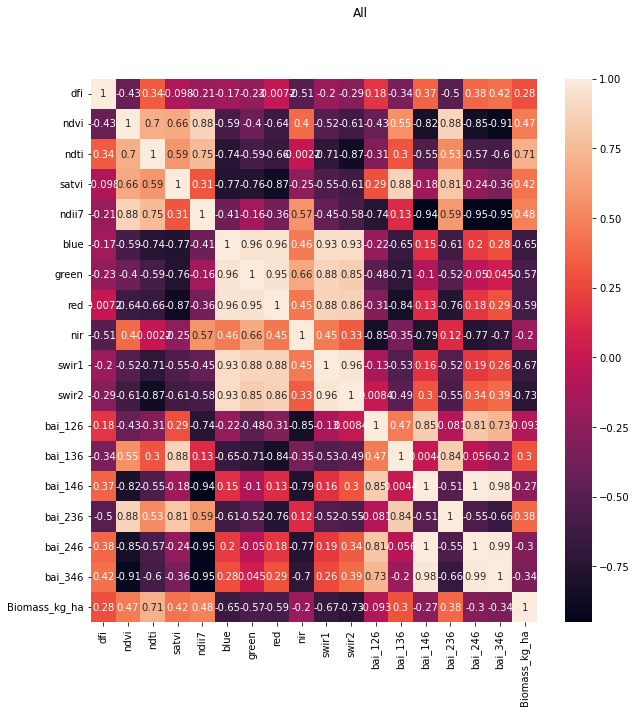

In [10]:
corrMatrix = X_vars_all.reset_index(drop=True).join(Y_var_all.reset_index(drop=True)).corr()
plt.figure(figsize=(10, 10))
plt.suptitle('All')
sns.heatmap(corrMatrix, annot=True)
#plt.show()

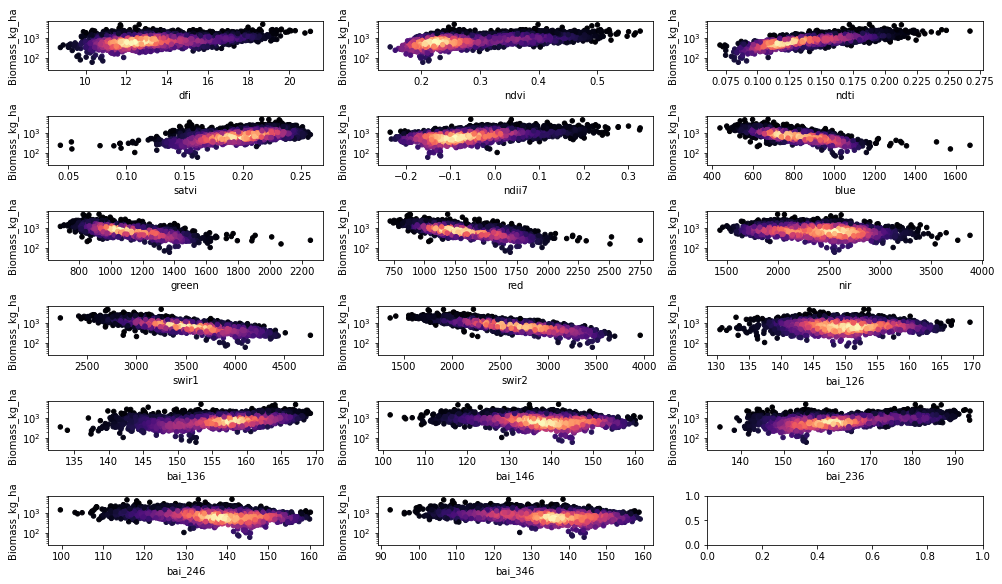

In [11]:
fig, axs = plt.subplots(figsize=(14, 8),
                        nrows=int(np.ceil(len(var_names) / 3)), ncols=3)
for idx, v in enumerate(var_names):
    xy_bm = np.vstack([df_vor[v], df_vor['Biomass_kg_ha']])
    z_bm = gaussian_kde(xy_bm)(xy_bm)
    df_vor.plot.scatter(x=v, y='Biomass_kg_ha', logy=True, ax=axs.flatten()[idx], ylim=(25, 7000),
                            c=z_bm, cmap='magma', colorbar=False)
    plt.tight_layout(pad=1.0)

In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

In [13]:
os.environ["PYTHONWARNINGS"] = 'ignore'# 'ignore::sklearn.exceptions.ConvergenceWarning:sklearn.model_selection.GridSearchCV'
import multiprocessing
multiprocessing.cpu_count()

12

In [36]:
mod_dict = {
    'LASSO': {
        'base_mod': Lasso(),
        'fit': True,
        'tune': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'alpha': np.logspace(-3, 3, num=20)
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': False,
        'interactions': True,
        'intxn_poly': 2
    },
    'PLS': {
        'base_mod': PLSRegression(n_components=1, scale=False),
        'fit': True,
        'tune': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'n_components': np.arange(1, len(var_names))
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': False,
        'interactions': True,
        'intxn_poly': 2
    },
    'PCR': {
        'base_mod': make_pipeline(PCA(), LinearRegression()),
        'fit': True,
        'tune': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'pca__n_components': np.arange(1, len(var_names))
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': False,
        'interactions': True,
        'intxn_poly': 2
    },
    'RF': {
        'base_mod': RandomForestRegressor(n_estimators=500, random_state=rand_st),
        'fit': False,
        'tune': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'bootstrap': [True],
            'max_depth': [None],
            'max_features': [2, 4, 6, len(var_names)],
            'min_samples_leaf': [1, 2, 5],
            'min_samples_split': [2, 5],
            'n_estimators': [500, 1000]
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': False,
        'interactions': False,
        'intxn_poly': 2
    },
    'SVR': {
        'base_mod': SVR(),
        'fit': False,
        'tune': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'C': [0.1, 0.51794747, 2.6826958, 13.89495494, 71.9685673, 372.75937203, 1930.69772888, 10000],
            'gamma': [0.0001, 0.00051795, 0.0026827, 0.01389495, 0.07196857, 0.37275937, 1.93069773, 10]
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': False,
        'interactions': False,
        'intxn_poly': 2
    },
    'GBR': {
        'base_mod': XGBRegressor(n_jobs=1, verbosity=0),
        'fit': True,
        'tune': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'learning_rate': [0.05, 0.1],
            'max_depth': [3],
            'min_child_weight': [1],
            'n_estimators': [100]
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': False,
        'interactions': True,
        'intxn_poly': 2
    }
}

In [37]:
scaler = StandardScaler()
mod_logo = LeaveOneGroupOut()
scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error', 'MAPE': 'neg_mean_absolute_percentage_error'}

if mod_dict['PLS']['fit'] and mod_dict['PLS']['tune']:
    df_vip = pd.DataFrame(columns=['Year', 'Variable', 'VIP', 'Coef'])
if mod_dict['LASSO']['fit']:
    df_lasso_coefs = pd.DataFrame(columns=['Year', 'Variable', 'Coef'])

In [38]:
from joblib import parallel_backend
import warnings
from sklearn.exceptions import ConvergenceWarning

In [39]:
for k in mod_dict:
    if mod_dict[k]['fit']:
        df_vor[k] = np.nan

for train_index, test_index in mod_logo.split(X_vars_all, groups=df_vor['Date'].dt.year, ):
    yr = df_vor['Date'].dt.year.iloc[test_index].unique()[0]
    print("Running K-fold = " + str(yr))

    train_loc = df_vor.iloc[train_index].index
    test_loc = df_vor.iloc[test_index].index
    
    all_y_orig = Y_var_all.iloc[train_index]
    all_Y_orig = Y_var_all.iloc[test_index]
    all_x_orig = df_vor[var_names].iloc[train_index, :]
    all_X_orig = df_vor[var_names].iloc[test_index, :]

    for k in mod_dict:
        if mod_dict[k]['fit']:
            print('....fitting ' + k)
            if mod_dict[k]['log_y']:
                print('to do...')
                break
            else:
                all_y = all_y_orig.copy()
                all_Y = all_Y_orig.copy()
            if mod_dict[k]['scale_x']:
                scaler.fit(all_x_orig)
                all_x = scaler.transform(all_x_orig)
                all_X = scaler.transform(all_X_orig)
            else:
                all_x = all_x_orig.copy()
                all_X = all_X_orig.copy()
        
            if mod_dict[k]['interactions']:
                poly_x = PolynomialFeatures(degree=mod_dict[k]['intxn_poly'], interaction_only=True, include_bias = False)
                all_x = poly_x.fit_transform(all_x)
                poly_X = PolynomialFeatures(degree=mod_dict[k]['intxn_poly'], interaction_only=True, include_bias = False)
                all_X = poly_X.fit_transform(all_X)

            # create a base model
            mod_base = mod_dict[k]['base_mod']
            
            if mod_dict[k]['tune']:
                cv_splitter = mod_logo.split(all_x, groups=df_vor['Date'].dt.year.iloc[train_index])
                grid_search = GridSearchCV(estimator=mod_base,
                                           param_grid=mod_dict[k]['param_grid'],
                                           scoring=scoring, 
                                           refit=mod_dict[k]['tune_refit'], 
                                           return_train_score=True,
                                           cv=cv_splitter, 
                                           n_jobs=multiprocessing.cpu_count() - 2, 
                                           verbose=2)
                
                with parallel_backend('loky'):
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=ConvergenceWarning)
                        grid_search.fit(all_x, all_y)
                mod_fnl = mod_base.set_params(**grid_search.best_params_)
                mod_fnl.fit(all_x, all_y)
                mod_dict[k]['tune_results'][yr] = grid_search.cv_results_
            else:
                mod_fnl = mod_base
    
            preds = mod_fnl.predict(all_X).squeeze()
            df_vor.loc[test_loc, k] = preds
        else:
            continue

Running K-fold = 2013
....fitting LASSO
Fitting 9 folds for each of 20 candidates, totalling 180 fits
....fitting PLS
Fitting 9 folds for each of 16 candidates, totalling 144 fits
....fitting PCR
Fitting 9 folds for each of 16 candidates, totalling 144 fits
....fitting GBR
Fitting 9 folds for each of 2 candidates, totalling 18 fits
Running K-fold = 2014
....fitting LASSO
Fitting 9 folds for each of 20 candidates, totalling 180 fits
....fitting PLS
Fitting 9 folds for each of 16 candidates, totalling 144 fits
....fitting PCR
Fitting 9 folds for each of 16 candidates, totalling 144 fits
....fitting GBR
Fitting 9 folds for each of 2 candidates, totalling 18 fits
Running K-fold = 2015
....fitting LASSO
Fitting 9 folds for each of 20 candidates, totalling 180 fits
[CV] END ........................................alpha=0.001; total time=   0.4s
[CV] END ..........................alpha=0.00206913808111479; total time=   0.4s
[CV] END .........................alpha=0.008858667904100823; total 

In [40]:
df_vor['Year'] = df_vor['Date'].dt.year
df_vor['Pasture'] = df_vor['Id'].apply(lambda x: x.split('_')[0])
df_vor['Plot'] = df_vor['Id'].apply(lambda x: x.split('_')[1])
if len(df_vor['Id'].iloc[0].split('_')) == 3:
    df_vor['Transect'] = df_vor['Id'].apply(lambda x: x.split('_')[-1])


In [41]:
df_bm_pred = pd.melt(df_vor.drop(columns=['Low', 'High', 'geometry', 'Date'] + var_names).rename(columns={'Biomass_kg_ha': 'Observed'}), 
                     id_vars=['Id', 'Pasture', 'Year', 'Date_mean', 'Plot', 'Season', 'Observed'], 
                     value_name='Predicted',
                     var_name='Source')

In [42]:
mae_plot = df_bm_pred.groupby(['Year', 'Source']).apply(
    lambda z: z.groupby(['Pasture', 'Plot', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
mape_plot = df_bm_pred.groupby(['Year', 'Source']).apply(
    lambda z: z.groupby(['Pasture', 'Plot', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)

In [43]:
mae_plot.unstack(level=-1)#.mean()

Source,GBR,LASSO,PCR,PLS
Year,,,,
2013,242.09,227.70,226.68,242.70
2014,316.87,321.90,326.70,317.01
2015,408.13,353.65,357.26,328.82
2016,241.59,221.75,213.56,217.73
2017,192.29,203.87,211.96,226.12
2018,236.99,215.87,210.08,207.66
2019,181.77,159.60,210.53,196.08
2020,112.26,119.22,100.72,118.20
2021,280.18,259.27,250.50,258.27


In [46]:
mape_plot.unstack(level=-1).mean()

Source
GBR      0.302
LASSO    0.297
PCR      0.296
PLS      0.298
dtype: float64

In [52]:
lr_form = df_results['formula'][413]

df_vor['bm_pred_lr_yr'] = np.nan
df_vor['bm_pred_lr_orig_yr'] = np.nan
df_vor['bm_pred_pls_yr'] = np.nan
df_vor['bm_pred_rf_yr'] = np.nan
df_vor['bm_pred_rft_yr'] = np.nan
df_vor['bm_pred_mlp_yr'] = np.nan
df_vor['bm_pred_svr_yr'] = np.nan
df_vor['bm_pred_lasso_yr'] = np.nan
df_vor['bm_pred_pcr_yr'] = np.nan

scaler = StandardScaler()
mod_logo = LeaveOneGroupOut()
mod_skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rand_st)
scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error', 'MAPE': 'neg_mean_absolute_percentage_error'}

param_grid_rf = {
    'bootstrap': [True],
    'max_depth': [None],
    'max_features': [2, 4, 6, len(var_names)],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 5],
    'n_estimators': [500, 1000]
}

param_grid_pls = {'n_components': np.arange(1, len(var_names))}

param_grid_lasso = {'alpha': np.logspace(-3, 3, num=20)}

param_grid_pcr = {'pca__n_components': np.arange(1, len(var_names))}

param_grid_svr = {'C': [0.1, 0.51794747, 2.6826958, 13.89495494, 71.9685673, 372.75937203, 1930.69772888, 10000],
                  'gamma': [0.0001, 0.00051795, 0.0026827, 0.01389495, 0.07196857, 0.37275937, 1.93069773, 10]}

wtd = False
scale_vars = True

log_xfrm = True
log_xfrm_pls = False
log_xfrm_lasso = False

pred_lr_2020 = True
fit_rf = False
fit_pls = True
fit_mlp = False
fit_svr = True
fit_lasso = True
fit_pcr = True

tune_rf = True
tune_pls = True
tune_pls_vip = True
tune_lasso = True
tune_pcr = True
tune_svr = True

intxn_ml = True
intxn_ml_poly = 2

n_comps_pls = []
n_comps_pcr = []
alphas = []
df_vip = pd.DataFrame(columns=['Year', 'Variable', 'VIP', 'Coef'])
df_lasso_coefs = pd.DataFrame(columns=['Year', 'Variable', 'Coef'])

for train_index, test_index in mod_logo.split(X_vars_all, groups=df_vor['Date'].dt.year, ):
    print("Running K-fold = " + str(df_vor['Date'].dt.year.iloc[test_index].unique()))
    
    all_y = Y_var_all.iloc[train_index]
    all_Y = Y_var_all.iloc[test_index]
    
    if wtd:
        lreg_tmp = smf.wls(formula=lr_form,
                           data=df_vor.iloc[train_index], weights=1 / df_vor.Biomass_kg_ha.iloc[train_index]).fit()
    else:
        lreg_tmp = smf.ols(formula=lr_form,
                           data=df_vor.iloc[train_index]).fit()
    if log_xfrm:
        see_tmp = np.sqrt(np.sum((np.log(df_vor['Biomass_kg_ha'].iloc[train_index]) -
                                  lreg_tmp.predict(df_vor.iloc[train_index])) ** 2) /
                          (len(train_index) - len(lreg_tmp.params)))
        cf_tmp = np.exp(see_tmp ** 2 / 2)  # correction factor from Sprugel 1983
        predictions_all_lr_tmp = np.exp(lreg_tmp.predict(df_vor.iloc[test_index]))# * cf_tmp
    else:
        predictions_all_lr_tmp = lreg_tmp.predict(df_vor.iloc[test_index])

    df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp

    if pred_lr_2020:
        predictions_lr_orig_tmp = np.exp(lr_mod.predict(df_vor.iloc[test_index]))
        df_vor['bm_pred_lr_orig_yr'].iloc[test_index] = predictions_lr_orig_tmp
        mae_all_full_lr_orig_ktests.append(round(np.mean(np.abs(predictions_lr_orig_tmp - all_Y)), 2))
        
    all_X = df_vor[var_names].iloc[test_index, :]
    all_x = df_vor[var_names].iloc[train_index, :]
       
    if scale_vars:
        scaler.fit(all_x)
        all_x = scaler.transform(all_x)
        all_X = scaler.transform(all_X)

    if intxn_ml:
        poly_x = PolynomialFeatures(degree=intxn_ml_poly, interaction_only=True, include_bias = False)
        all_x = poly_x.fit_transform(all_x)
        poly_X = PolynomialFeatures(degree=intxn_ml_poly, interaction_only=True, include_bias = False)
        all_X = poly_X.fit_transform(all_X)
    
    if fit_rf:
        rf_all_tmp = RandomForestRegressor(n_estimators=500, random_state=rand_st)
        rf_all_tmp.fit(all_x, all_y)
        predictions_all_tmp = rf_all_tmp.predict(all_X)
        df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
        
        if tune_rf:
            #rf_cv_all = mod_skf.split(all_x, df_vor['Year'].iloc[train_index])
            rf_cv_all = mod_logo.split(all_x, groups=df_vor['Date'].dt.year.iloc[train_index])
    
            # Create a base model
            rf_all_m1 = RandomForestRegressor(random_state=rand_st)
            # Instantiate the grid search model
            grid_search_all_m1 = GridSearchCV(estimator=rf_all_m1,
                                              param_grid=param_grid_rf,
                                              scoring=scoring, 
                                              refit='MAPE', 
                                              return_train_score=True,
                                              cv=rf_cv_all, 
                                              n_jobs=-5, 
                                              verbose=0)
            grid_search_all_m1.fit(all_x, all_y)
            params_all_m1 = grid_search_all_m1.best_params_
            rf_all_m2 = RandomForestRegressor(n_estimators=params_all_m1['n_estimators'],
                                              min_samples_split=params_all_m1['min_samples_split'],
                                              min_samples_leaf=params_all_m1['min_samples_leaf'],
                                              max_features=params_all_m1['max_features'],
                                              bootstrap=params_all_m1['bootstrap'],
                                              max_depth=params_all_m1['max_depth'],
                                              random_state=rand_st)
            rf_all_m2.fit(all_x, all_y)
            # Use the forest's predict method on the test data
            predictions_all_tmp_m2 = rf_all_m2.predict(all_X)
            df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_all_tmp_m2
    if fit_mlp:
        mlp_all = MLPRegressor(solver='lbfgs', learning_rate='adaptive', max_iter=2000)
        mlp_all.fit(all_x, all_y)
        predictions_all_tmp_mlp = mlp_all.predict(all_X)
        df_vor['bm_pred_mlp_yr'].iloc[test_index] = predictions_all_tmp_mlp

    if fit_pls:
        if tune_pls:
            pls_cv_all = mod_logo.split(all_x, groups=df_vor['Date'].dt.year.iloc[train_index])
            
            # Create a base model
            pls_all_m1 = PLSRegression(scale=False)
            # Instantiate the grid search model
            grid_search_all_m1 = GridSearchCV(estimator=pls_all_m1,
                                              param_grid=param_grid_pls,
                                              scoring=scoring, 
                                              refit='MAPE', 
                                              return_train_score=True,
                                              cv=pls_cv_all, 
                                              n_jobs=5, 
                                              verbose=0)
            if log_xfrm_pls:
                grid_search_all_m1.fit(all_x, np.log(all_y))
            else:
                grid_search_all_m1.fit(all_x, all_y)
            params_all_m1 = grid_search_all_m1.best_params_
            n_comps_pls.append(params_all_m1['n_components'])
            pls_all = PLSRegression(n_components=params_all_m1['n_components'], scale=False)
        else:
            pls_all = PLSRegression(n_components=10, scale=False)
        if log_xfrm_pls:
            pls_all.fit(all_x, np.log(all_y))
        else:
            pls_all.fit(all_x, all_y)
        
        if intxn_ml:
            var_names_out = poly_x.get_feature_names(var_names)
        else:
            var_names_out = var_names
        
        pls_vip = vip(all_x, all_y, pls_all)
        pls_coefs = abs(pls_all.coef_).squeeze()
        
        if tune_pls_vip:
            all_x_vip_adj = all_x[:, pls_vip > 1.0]
            all_X_vip_adj = all_X[:, pls_vip > 1.0]
            pls_all.fit(all_x_vip_adj, all_y)
            var_names_out_pls = [x for idx, x in enumerate(var_names_out) if pls_vip[idx] > 1.0]
            pls_coefs = pls_coefs[pls_vip > 1.0]
            pls_vip = pls_vip[pls_vip > 1.0]
        else:
            all_X_vip_adj = all_X
            var_names_out_pls = var_names_out
        
        if log_xfrm_pls:
            see_tmp = np.sqrt(np.sum((np.log(df_vor['Biomass_kg_ha'].iloc[train_index]) -
                          pls_all.predict(all_x).squeeze()) ** 2) /
                  (all_x.shape[0] - all_x.shape[1]))
            cf_tmp = np.exp(see_tmp ** 2 / 2)  # correction factor from Sprugel 1983
            predictions_all_tmp_pls = np.exp(pls_all.predict(all_X_vip_adj).squeeze())# * cf_tmp
        else:
            predictions_all_tmp_pls = pls_all.predict(all_X_vip_adj).squeeze()
        
        predictions_all_tmp_pls[predictions_all_tmp_pls < 0.0] = 0.0
        df_vor['bm_pred_pls_yr'].iloc[test_index] = predictions_all_tmp_pls
        
        df_vip = pd.concat([df_vip,
                            pd.DataFrame({'Year': str(df_vor['Date'].dt.year.iloc[test_index].unique()[0]),
                                          'Variable': var_names_out_pls,
                                          'VIP': pls_vip,
                                          'Coef': pls_coefs})])
    if fit_svr:
        if tune_svr:
            print('Tuning SVR...')
            svr_cv_all = mod_logo.split(all_x, groups=df_vor['Date'].dt.year.iloc[train_index])
            # Create a base model
            svr_all_m1 = SVR()
            # Instantiate the grid search model
            grid_search_svr = GridSearchCV(estimator=svr_all_m1,
                                              param_grid=param_grid_svr,
                                              scoring=scoring, 
                                              refit='MAPE', 
                                              return_train_score=True,
                                              cv=svr_cv_all, 
                                              n_jobs=5, 
                                              verbose=0)
            grid_search_svr.fit(all_x, all_y)
            params_svr = grid_search_svr.best_params_
            svr_all = SVR(gamma=params_svr['gamma'], C=params_svr['C'])
        else:
            svr_all = SVR()
        svr_all.fit(all_x, all_y)
        predictions_all_tmp_svr = svr_all.predict(all_X).squeeze()
        df_vor['bm_pred_svr_yr'].iloc[test_index] = predictions_all_tmp_svr

    if fit_lasso:
        if tune_lasso:
            print('tuning LASSO...')
            lasso_cv_all = mod_logo.split(all_x, groups=df_vor['Date'].dt.year.iloc[train_index])
            
            # Create a base model
            lasso_all_m1 = Lasso()
            # Instantiate the grid search model
            grid_search_all_m1 = GridSearchCV(estimator=lasso_all_m1,
                                              param_grid=param_grid_lasso,
                                              scoring=scoring, 
                                              refit='MAPE', 
                                              return_train_score=True,
                                              cv=lasso_cv_all, 
                                              n_jobs=5, 
                                              verbose=0)
            if log_xfrm_lasso:
                grid_search_all_m1.fit(all_x, np.log(all_y))
            else:
                grid_search_all_m1.fit(all_x, all_y)
            params_all_m1 = grid_search_all_m1.best_params_
            alphas.append(params_all_m1['alpha'])
            lasso_all = Lasso(alpha=params_all_m1['alpha'])
        else:
            lasso_all = Lasso()
        
        lasso_all.fit(all_x, all_y)

        if tune_lasso:
            lasso_coefs = abs(lasso_all.coef_)
            var_names_out_lasso = [x for idx, x in enumerate(var_names_out) if abs(lasso_coefs[idx]) != 0.0]
            lasso_coefs = lasso_coefs[abs(lasso_coefs) > 0.0]
            df_lasso_coefs = pd.concat([df_lasso_coefs,
                            pd.DataFrame({'Year': str(df_vor['Date'].dt.year.iloc[test_index].unique()[0]),
                                          'Variable': var_names_out_lasso,
                                          'Coef': lasso_coefs})])
        
        predictions_all_tmp_lasso = lasso_all.predict(all_X)
        df_vor['bm_pred_lasso_yr'].iloc[test_index] = predictions_all_tmp_lasso

    if fit_pcr:
        if tune_pcr:
            print('tuning PCR...')
            pcr_cv_all = mod_logo.split(all_x, groups=df_vor['Date'].dt.year.iloc[train_index])
            
            # Create a base model
            pcr_mod_m1 = make_pipeline(PCA(), LinearRegression())
            # Instantiate the grid search model
            grid_search_all_m1 = GridSearchCV(estimator=pcr_mod_m1,
                                              param_grid=param_grid_pcr,
                                              scoring=scoring, 
                                              refit='MAPE', 
                                              return_train_score=True,
                                              cv=pcr_cv_all, 
                                              n_jobs=5, 
                                              verbose=0)
            if log_xfrm_lasso:
                grid_search_all_m1.fit(all_x, np.log(all_y))
            else:
                grid_search_all_m1.fit(all_x, all_y)
            params_all_m1 = grid_search_all_m1.best_params_
            n_comps_pcr.append(params_all_m1['pca__n_components'])
            pcr_all = make_pipeline(PCA(n_components=params_all_m1['pca__n_components']), LinearRegression())
        else:
            pcr_all = make_pipeline(PCA(n_components=10), LinearRegression())
        pcr_all.fit(all_x, all_y)
        predictions_all_tmp_pcr = pcr_all.predict(all_X)
        df_vor['bm_pred_pcr_yr'].iloc[test_index] = predictions_all_tmp_pcr

Running K-fold = [2013]


/tmp/ipykernel_16585/2728796418.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_16585/2728796418.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_orig_yr'].iloc[test_index] = predictions_lr_orig_tmp
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/

Tuning SVR...


/tmp/ipykernel_16585/2728796418.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_svr_yr'].iloc[test_index] = predictions_all_tmp_svr


tuning LASSO...


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.881e+07, tolerance: 4.589e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.573e+07, tolerance: 4.011e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

tuning PCR...


/tmp/ipykernel_16585/2728796418.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pcr_yr'].iloc[test_index] = predictions_all_tmp_pcr
/tmp/ipykernel_16585/2728796418.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_16585/2728796418.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_orig_yr'].iloc[test_index] = p

Running K-fold = [2014]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_16585/2728796418.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Tuning SVR...


/tmp/ipykernel_16585/2728796418.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_svr_yr'].iloc[test_index] = predictions_all_tmp_svr
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.582e+07, tolerance: 4.011e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing

tuning LASSO...


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.544e+07, tolerance: 3.955e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.939e+07, tolerance: 3.791e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

tuning PCR...


/tmp/ipykernel_16585/2728796418.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pcr_yr'].iloc[test_index] = predictions_all_tmp_pcr
/tmp/ipykernel_16585/2728796418.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_16585/2728796418.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_orig_yr'].iloc[test_index] = p

Running K-fold = [2015]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_16585/2728796418.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Tuning SVR...


/tmp/ipykernel_16585/2728796418.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_svr_yr'].iloc[test_index] = predictions_all_tmp_svr
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.753e+07, tolerance: 3.523e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing

tuning LASSO...


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.606e+07, tolerance: 4.733e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.149e+07, tolerance: 4.412e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

tuning PCR...


/tmp/ipykernel_16585/2728796418.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pcr_yr'].iloc[test_index] = predictions_all_tmp_pcr
/tmp/ipykernel_16585/2728796418.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_16585/2728796418.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_orig_yr'].iloc[test_index] = p

Running K-fold = [2016]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_16585/2728796418.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Tuning SVR...


/tmp/ipykernel_16585/2728796418.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_svr_yr'].iloc[test_index] = predictions_all_tmp_svr
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.977e+07, tolerance: 3.385e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing

tuning LASSO...


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.722e+07, tolerance: 4.582e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.021e+07, tolerance: 4.266e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

tuning PCR...


/tmp/ipykernel_16585/2728796418.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pcr_yr'].iloc[test_index] = predictions_all_tmp_pcr
/tmp/ipykernel_16585/2728796418.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_16585/2728796418.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_orig_yr'].iloc[test_index] = p

Running K-fold = [2017]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_16585/2728796418.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Tuning SVR...


/tmp/ipykernel_16585/2728796418.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_svr_yr'].iloc[test_index] = predictions_all_tmp_svr
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.807e+07, tolerance: 4.547e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing

tuning LASSO...


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.355e+07, tolerance: 5.104e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.096e+07, tolerance: 4.877e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

tuning PCR...


/tmp/ipykernel_16585/2728796418.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pcr_yr'].iloc[test_index] = predictions_all_tmp_pcr
/tmp/ipykernel_16585/2728796418.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_16585/2728796418.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_orig_yr'].iloc[test_index] = p

Running K-fold = [2018]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_16585/2728796418.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Tuning SVR...


/tmp/ipykernel_16585/2728796418.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_svr_yr'].iloc[test_index] = predictions_all_tmp_svr
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.156e+07, tolerance: 4.904e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing

tuning LASSO...


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.267e+07, tolerance: 4.599e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.014e+07, tolerance: 4.901e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

tuning PCR...


/tmp/ipykernel_16585/2728796418.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pcr_yr'].iloc[test_index] = predictions_all_tmp_pcr
/tmp/ipykernel_16585/2728796418.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_16585/2728796418.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_orig_yr'].iloc[test_index] = p

Running K-fold = [2019]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_16585/2728796418.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Tuning SVR...


/tmp/ipykernel_16585/2728796418.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_svr_yr'].iloc[test_index] = predictions_all_tmp_svr
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.608e+07, tolerance: 4.733e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing

tuning LASSO...


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.684e+07, tolerance: 4.818e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.332e+07, tolerance: 4.864e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

tuning PCR...


/tmp/ipykernel_16585/2728796418.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pcr_yr'].iloc[test_index] = predictions_all_tmp_pcr
/tmp/ipykernel_16585/2728796418.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_16585/2728796418.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_orig_yr'].iloc[test_index] = p

Running K-fold = [2020]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_16585/2728796418.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Tuning SVR...


/tmp/ipykernel_16585/2728796418.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_svr_yr'].iloc[test_index] = predictions_all_tmp_svr
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.760e+07, tolerance: 4.828e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing

tuning LASSO...


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.457e+07, tolerance: 4.634e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.003e+07, tolerance: 4.556e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

tuning PCR...


/tmp/ipykernel_16585/2728796418.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pcr_yr'].iloc[test_index] = predictions_all_tmp_pcr
/tmp/ipykernel_16585/2728796418.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_16585/2728796418.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_orig_yr'].iloc[test_index] = p

Running K-fold = [2021]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_16585/2728796418.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Tuning SVR...


/tmp/ipykernel_16585/2728796418.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_svr_yr'].iloc[test_index] = predictions_all_tmp_svr
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.652e+07, tolerance: 4.802e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing

tuning LASSO...


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.263e+07, tolerance: 4.599e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.024e+07, tolerance: 4.266e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

tuning PCR...


/tmp/ipykernel_16585/2728796418.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pcr_yr'].iloc[test_index] = predictions_all_tmp_pcr
/tmp/ipykernel_16585/2728796418.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_16585/2728796418.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_orig_yr'].iloc[test_index] = p

Running K-fold = [2022]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_16585/2728796418.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Tuning SVR...


/tmp/ipykernel_16585/2728796418.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_svr_yr'].iloc[test_index] = predictions_all_tmp_svr
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.441e+07, tolerance: 4.862e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing

tuning LASSO...


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.773e+07, tolerance: 4.518e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.787e+07, tolerance: 4.599e+04
  model = cd_fast.enet_coordinate_descent(
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

tuning PCR...


/tmp/ipykernel_16585/2728796418.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pcr_yr'].iloc[test_index] = predictions_all_tmp_pcr
Bad pipe message: %s [b'\x8f\xc6jK\x1c4M\xa4:\x8a\xed\xe42\x7f\xd0\x02[3\x00\x01p\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00', b'@\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00A\x00B\x00C\x00D\x00E\x00F\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00']
Bad pipe message: %s [b"\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x

In [36]:
print(n_comps_pls)
print(n_comps_pcr)

[5, 5, 4, 5, 5, 5, 6, 5, 5, 6]
[12, 12, 12, 14, 12, 12, 14, 12, 10, 12]


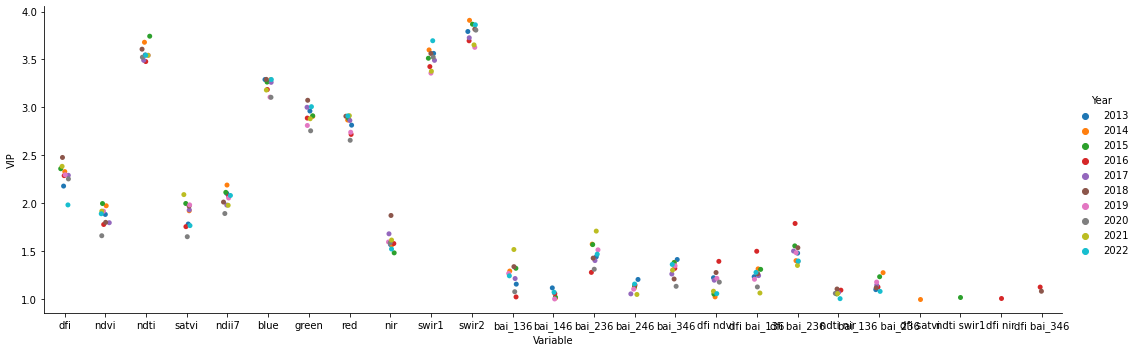

In [26]:
sns.catplot(df_vip[df_vip['VIP'] > 1.0], x='Variable', y='VIP', hue='Year', aspect=3)

In [27]:
df_vip[df_vip['VIP'] > 1.0].groupby('Variable')['VIP'].count().sort_values(ascending=False)#['Variable'].unique()

Variable
bai_136            10
dfi ndvi           10
swir1              10
satvi              10
red                10
nir                10
ndvi               10
ndti               10
ndii7              10
green              10
swir2              10
dfi bai_236        10
dfi bai_136        10
dfi                10
blue               10
bai_346            10
bai_236            10
bai_136 bai_236     8
ndti nir            8
bai_246             8
bai_146             6
dfi bai_346         2
dfi satvi           1
ndti swir1          1
dfi nir             1
Name: VIP, dtype: int64

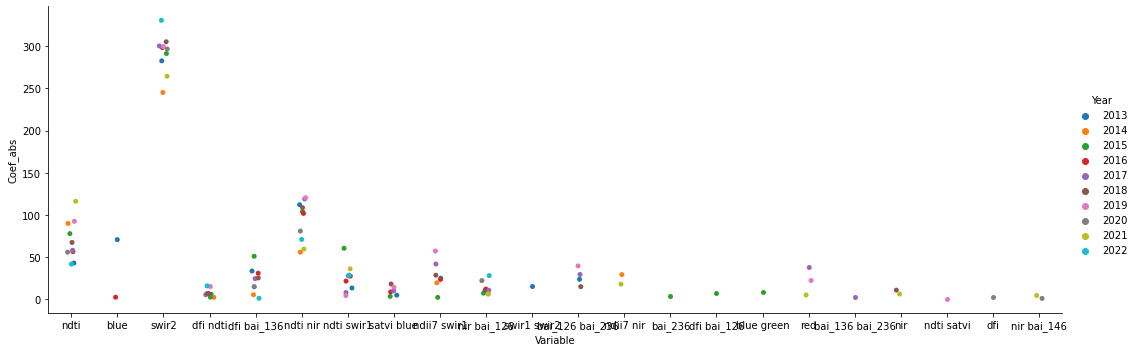

In [28]:
df_lasso_coefs['Coef_abs'] = abs(df_lasso_coefs['Coef'])
sns.catplot(df_lasso_coefs, x='Variable', y='Coef_abs', hue='Year', aspect=3)

In [37]:
df_lasso_coefs.groupby('Variable')['Coef'].count().sort_values(ascending=False)#['Variable'].unique()

Variable
ndti               10
ndti nir           10
swir2              10
ndti swir1          9
dfi bai_136         9
dfi ndti            8
nir bai_126         8
ndii7 swir1         7
satvi blue          6
bai_126 bai_236     4
red                 3
nir bai_146         2
nir                 2
blue                2
ndii7 nir           2
ndti satvi          1
blue green          1
bai_136 bai_236     1
dfi bai_126         1
dfi                 1
swir1 swir2         1
bai_236             1
Name: Coef, dtype: int64

In [53]:
mod_dict = {
    'LR_orig': 'bm_pred_lr_orig_yr',
    'LR': 'bm_pred_lr_yr',
    'PLS': 'bm_pred_pls_yr',
    'LASSO': 'bm_pred_lasso_yr',
    'PCR': 'bm_pred_pcr_yr',
    'RF': 'bm_pred_rft_yr',
    'SVR': 'bm_pred_svr_yr'
}

In [54]:
df_vor['Pasture'] = df_vor['Id'].apply(lambda x: x.split('_')[0])
df_vor['Plot'] = df_vor['Id'].apply(lambda x: x.split('_')[1])
df_vor['Year'] = df_vor['Date'].dt.year

#### Transect-scale performance

In [55]:
if len(df_vor['Id'].iloc[0].split('_')) == 3:
    df_vor['Transect'] = df_vor['Id'].apply(lambda x: x.split('_')[-1])
    for k in mod_dict:
        print("----- " + k + " -----")
        print("MAE: " + 
              str(np.round(df_vor.groupby(['Pasture', 'Plot', 'Transect', 'Date']).apply(
                  lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha']))).mean() , 2)) + 
              " (sd = " +
              str(np.round(df_vor.groupby(['Pasture', 'Plot', 'Transect', 'Date']).apply(
                  lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha']))).std() , 2)) + 
              ") kg/ha")
        display(np.round(df_vor.groupby(['Pasture', 'Plot', 'Transect', 'Date', 'Year']).apply(
                  lambda x: np.mean(abs(x[mod_dict[k]] - x['Biomass_kg_ha']))).groupby(['Year']).mean() , 2))
        print("\nMAPE: " + 
              str(np.round(df_vor.groupby(['Pasture', 'Plot', 'Transect', 'Date']).apply(
                  lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).mean(), 2)) + 
              " (sd = " +
              str(np.round(df_vor.groupby(['Pasture', 'Plot', 'Transect', 'Date']).apply(
                  lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).std() , 2)) + 
              ") kg/ha")
        display(np.round(df_vor.groupby(['Pasture', 'Plot', 'Transect', 'Date', 'Year']).apply(
                  lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).groupby(['Year']).mean() , 2))
        print("\n\n")

#### Plot-scale performance

In [56]:
for k in mod_dict:
    print("----- " + k + " -----")
    print("MAE: " + 
          str(np.round(df_vor.groupby(['Pasture', 'Plot', 'Date']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha']))).mean() , 2)) + 
          " (sd = " +
          str(np.round(df_vor.groupby(['Pasture', 'Plot', 'Date']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha']))).std() , 2)) + 
          ") kg/ha")
    display(np.round(df_vor.groupby(['Pasture', 'Plot', 'Date', 'Year']).apply(
              lambda x: np.mean(abs(x[mod_dict[k]] - x['Biomass_kg_ha']))).groupby(['Year']).mean() , 2))
    print("\nMAPE: " + 
          str(np.round(df_vor.groupby(['Pasture', 'Plot', 'Date']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).mean(), 2)) + 
          " (sd = " +
          str(np.round(df_vor.groupby(['Pasture', 'Plot', 'Date']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).std() , 2)) + 
          ") kg/ha")
    display(np.round(df_vor.groupby(['Pasture', 'Plot', 'Date', 'Year']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).groupby(['Year']).mean() , 2))
    print("\n\n")

----- LR_orig -----
MAE: 258.0 (sd = 278.6) kg/ha


Year
2013    268.92
2014    363.03
2015    232.09
2016    276.47
2017    214.80
2018    329.79
2019    219.08
2020    141.73
2021    331.51
2022    214.76
dtype: float64


MAPE: 0.3 (sd = 0.31) kg/ha


Year
2013    0.47
2014    0.27
2015    0.20
2016    0.23
2017    0.22
2018    0.36
2019    0.25
2020    0.30
2021    0.31
2022    0.43
dtype: float64




----- LR -----
MAE: 218.15 (sd = 238.81) kg/ha


Year
2013    217.01
2014    316.72
2015    295.66
2016    215.98
2017    190.29
2018    218.90
2019    185.28
2020    101.64
2021    269.88
2022    176.91
dtype: float64


MAPE: 0.26 (sd = 0.3) kg/ha


Year
2013    0.40
2014    0.27
2015    0.32
2016    0.18
2017    0.23
2018    0.23
2019    0.21
2020    0.22
2021    0.26
2022    0.36
dtype: float64




----- PLS -----
MAE: 231.79 (sd = 237.19) kg/ha


Year
2013    243.00
2014    345.01
2015    351.82
2016    221.18
2017    231.64
2018    211.61
2019    151.38
2020    131.81
2021    251.92
2022    199.55
dtype: float64


MAPE: 0.3 (sd = 0.34) kg/ha


Year
2013    0.48
2014    0.32
2015    0.38
2016    0.19
2017    0.30
2018    0.22
2019    0.19
2020    0.27
2021    0.26
2022    0.41
dtype: float64




----- LASSO -----
MAE: 225.55 (sd = 237.3) kg/ha


Year
2013    227.70
2014    321.90
2015    353.65
2016    221.75
2017    203.87
2018    215.87
2019    159.60
2020    119.22
2021    259.27
2022    188.07
dtype: float64


MAPE: 0.29 (sd = 0.36) kg/ha


Year
2013    0.45
2014    0.28
2015    0.40
2016    0.19
2017    0.26
2018    0.23
2019    0.19
2020    0.27
2021    0.27
2022    0.43
dtype: float64




----- PCR -----
MAE: 229.0 (sd = 233.17) kg/ha


Year
2013    226.68
2014    326.70
2015    357.26
2016    213.56
2017    211.96
2018    210.08
2019    210.53
2020    100.72
2021    250.50
2022    189.88
dtype: float64


MAPE: 0.29 (sd = 0.35) kg/ha


Year
2013    0.45
2014    0.30
2015    0.39
2016    0.19
2017    0.27
2018    0.22
2019    0.24
2020    0.22
2021    0.26
2022    0.42
dtype: float64




----- RF -----
MAE: nan (sd = nan) kg/ha


Year
2013   NaN
2014   NaN
2015   NaN
2016   NaN
2017   NaN
2018   NaN
2019   NaN
2020   NaN
2021   NaN
2022   NaN
dtype: float64


MAPE: nan (sd = nan) kg/ha


Year
2013   NaN
2014   NaN
2015   NaN
2016   NaN
2017   NaN
2018   NaN
2019   NaN
2020   NaN
2021   NaN
2022   NaN
dtype: float64




----- SVR -----
MAE: 227.74 (sd = 249.66) kg/ha


Year
2013    209.70
2014    325.28
2015    275.53
2016    233.05
2017    199.71
2018    236.50
2019    208.30
2020    102.98
2021    299.41
2022    183.32
dtype: float64


MAPE: 0.28 (sd = 0.32) kg/ha


Year
2013    0.39
2014    0.27
2015    0.30
2016    0.19
2017    0.25
2018    0.25
2019    0.23
2020    0.24
2021    0.28
2022    0.40
dtype: float64

#### Pasture scale

In [103]:
for k in mod_dict:
    print("----- " + k + " -----")
    print("MAE: " + 
          str(np.round(df_vor.groupby(['Pasture', 'Date_mean']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha']))).mean() , 2)) + 
          " (sd = " +
          str(np.round(df_vor.groupby(['Pasture', 'Date_mean']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha']))).std() , 2)) + 
          ") kg/ha")
    display(np.round(df_vor.groupby(['Date_mean', 'Pasture', 'Year']).apply(
              lambda x: np.mean(abs(x[mod_dict[k]] - x['Biomass_kg_ha']))).groupby(['Year']).mean() , 2))
    print("\nMAPE: " + 
          str(np.round(df_vor.groupby(['Pasture', 'Date_mean']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).mean(), 2)) + 
          " (sd = " +
          str(np.round(df_vor.groupby(['Pasture', 'Date_mean']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).std() , 2)) + 
          ") kg/ha")
    display(np.round(df_vor.groupby(['Date_mean', 'Pasture', 'Year']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).groupby(['Year']).mean() , 2))
    print('\n\n')

----- LR_orig -----
MAE: 226.51 (sd = 220.65) kg/ha


Year
2013    259.38
2014    344.04
2015    224.39
2016    268.31
2017    207.57
2018    308.15
2019    219.64
2020    136.98
2021    313.51
2022    205.54
dtype: float64


MAPE: 0.27 (sd = 0.26) kg/ha


Year
2013    0.47
2014    0.25
2015    0.16
2016    0.19
2017    0.21
2018    0.33
2019    0.23
2020    0.27
2021    0.28
2022    0.39
dtype: float64




----- LR -----
MAE: 179.0 (sd = 178.98) kg/ha


Year
2013    210.77
2014    304.85
2015    298.03
2016    210.17
2017    188.26
2018    202.37
2019    181.78
2020     98.66
2021    251.33
2022    168.09
dtype: float64


MAPE: 0.22 (sd = 0.24) kg/ha


Year
2013    0.37
2014    0.24
2015    0.28
2016    0.14
2017    0.19
2018    0.18
2019    0.18
2020    0.17
2021    0.22
2022    0.31
dtype: float64




----- PLS -----
MAE: 195.33 (sd = 184.74) kg/ha


Year
2013    238.65
2014    332.79
2015    355.81
2016    219.24
2017    234.42
2018    197.47
2019    151.36
2020    128.42
2021    238.12
2022    192.85
dtype: float64


MAPE: 0.26 (sd = 0.28) kg/ha


Year
2013    0.45
2014    0.29
2015    0.35
2016    0.15
2017    0.25
2018    0.18
2019    0.14
2020    0.23
2021    0.21
2022    0.37
dtype: float64




----- LASSO -----
MAE: 188.24 (sd = 185.97) kg/ha


Year
2013    222.92
2014    307.22
2015    359.51
2016    219.19
2017    204.56
2018    200.23
2019    157.10
2020    115.78
2021    243.53
2022    181.75
dtype: float64


MAPE: 0.25 (sd = 0.3) kg/ha


Year
2013    0.42
2014    0.25
2015    0.36
2016    0.16
2017    0.21
2018    0.18
2019    0.15
2020    0.22
2021    0.22
2022    0.38
dtype: float64




----- PCR -----
MAE: 190.45 (sd = 183.22) kg/ha


Year
2013    222.08
2014    316.40
2015    363.10
2016    211.51
2017    214.01
2018    194.08
2019    206.64
2020     98.13
2021    235.85
2022    183.62
dtype: float64


MAPE: 0.25 (sd = 0.29) kg/ha


Year
2013    0.42
2014    0.27
2015    0.36
2016    0.15
2017    0.23
2018    0.17
2019    0.22
2020    0.14
2021    0.21
2022    0.37
dtype: float64




----- RF -----
MAE: nan (sd = nan) kg/ha


Year
2013   NaN
2014   NaN
2015   NaN
2016   NaN
2017   NaN
2018   NaN
2019   NaN
2020   NaN
2021   NaN
2022   NaN
dtype: float64


MAPE: nan (sd = nan) kg/ha


Year
2013   NaN
2014   NaN
2015   NaN
2016   NaN
2017   NaN
2018   NaN
2019   NaN
2020   NaN
2021   NaN
2022   NaN
dtype: float64




----- SVR -----
MAE: 188.98 (sd = 195.01) kg/ha


Year
2013    203.17
2014    308.65
2015    278.22
2016    227.15
2017    199.19
2018    218.45
2019    204.62
2020    100.89
2021    278.80
2022    176.94
dtype: float64


MAPE: 0.24 (sd = 0.26) kg/ha


Year
2013    0.37
2014    0.23
2015    0.25
2016    0.16
2017    0.20
2018    0.20
2019    0.21
2020    0.18
2021    0.24
2022    0.35
dtype: float64

In [111]:
df_bm_pred = pd.melt(df_vor.drop(columns=['Low', 'High', 'geometry', 'Date'] + var_names).rename(columns={'Biomass_kg_ha': 'Observed'}), 
                     id_vars=['Id', 'Pasture', 'Year', 'Date_mean', 'Plot', 'Season', 'Observed'], 
                     value_name='Predicted',
                     var_name='Source')

In [80]:
print("MAE: " + 
          str(np.round(df_bm_pred.groupby(['Pasture', 'Date', 'Source']).apply(
              lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean() , 2)) + 
          " (sd = " +
          str(np.round(df_bm_pred.groupby(['Pasture', 'Date', 'Source']).apply(
              lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).std() , 2)) + 
          ") kg/ha")

MAE: 206.2 (sd = 205.5) kg/ha


In [129]:
test = df_bm_pred.groupby(['Year', 'Source']).apply(
    lambda z: z.groupby(['Pasture', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean())

In [131]:
test.unstack(level=-1).mean()

Source
bm_pred_lasso_yr      189.384860
bm_pred_lr_orig_yr    227.755156
bm_pred_lr_yr         179.192621
bm_pred_mlp_yr               NaN
bm_pred_pcr_yr        190.697593
bm_pred_pls_yr        197.095100
bm_pred_rf_yr                NaN
bm_pred_rft_yr               NaN
bm_pred_svr_yr        188.115019
dtype: float64

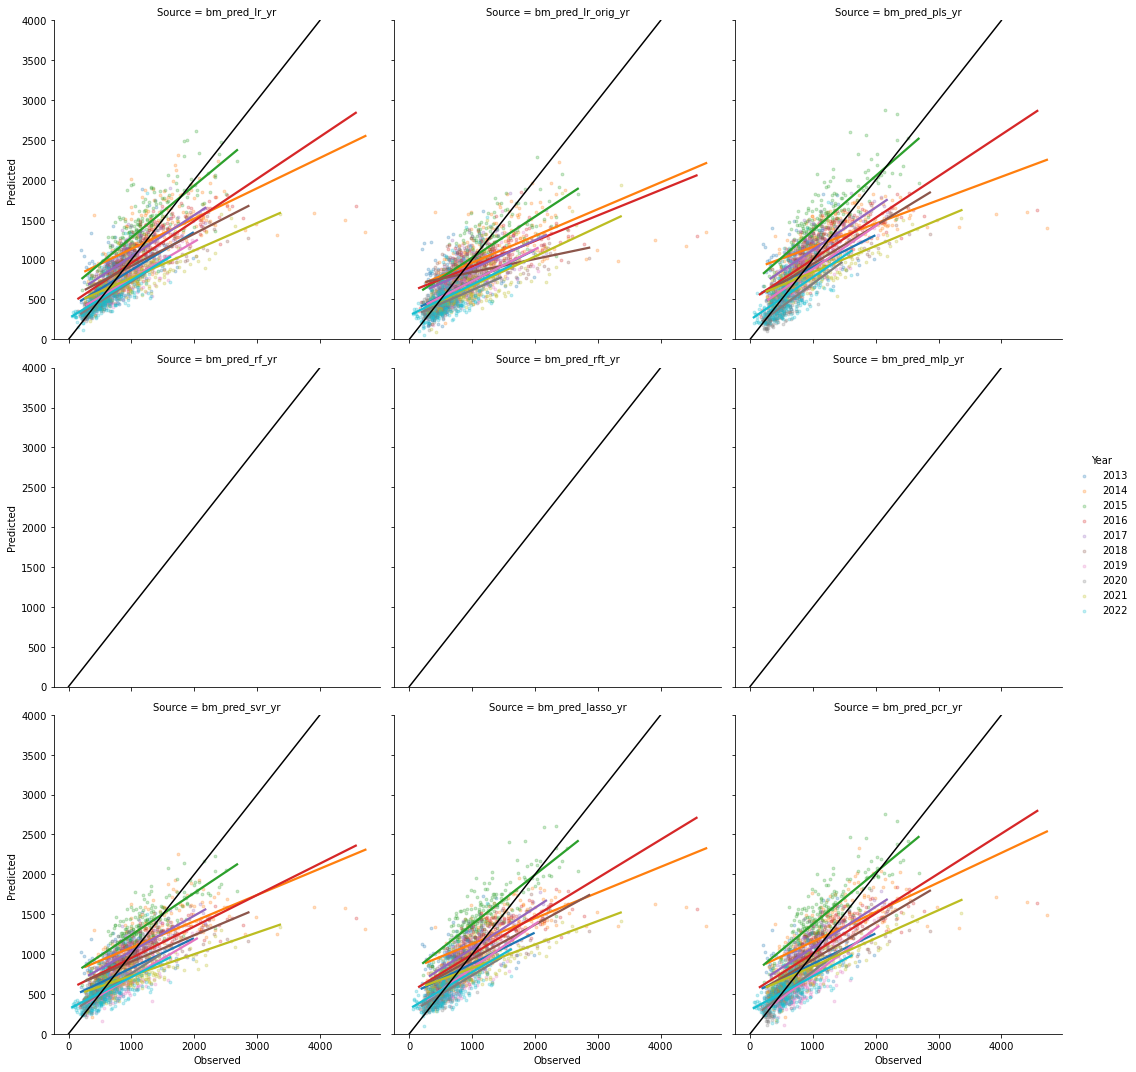

In [78]:
import seaborn as sns
p = sns.lmplot(df_bm_pred, x='Observed', y='Predicted', col='Source', col_wrap=3, hue='Year', ci=None, scatter_kws={'s': 8, 'alpha': 0.25})
for ax in p.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')

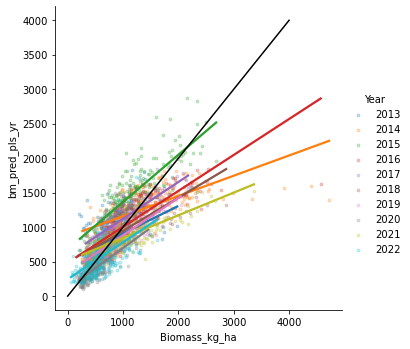

In [48]:
p2 = sns.lmplot(df_vor, x='Biomass_kg_ha', y='bm_pred_pls_yr', hue='Year', ci=None, scatter_kws={'s': 8, 'alpha': 0.25})
p2.axes[0, 0].plot(np.arange(0, 4000), np.arange(0, 4000), c='black')

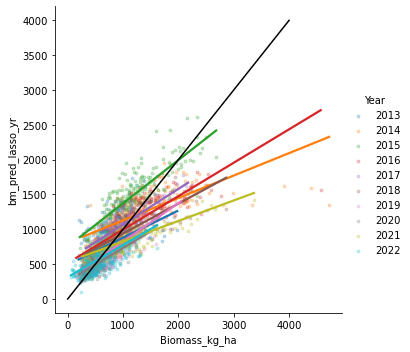

In [49]:
p3 = sns.lmplot(df_vor, x='Biomass_kg_ha', y='bm_pred_lasso_yr', hue='Year', ci=None, scatter_kws={'s': 8, 'alpha': 0.25})
p3.axes[0, 0].plot(np.arange(0, 4000), np.arange(0, 4000), c='black')

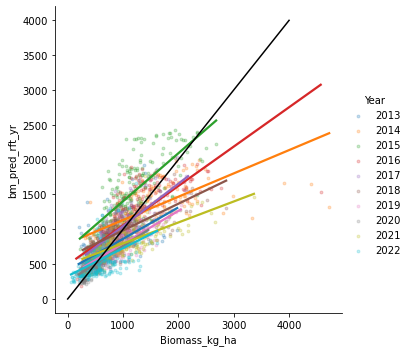

In [46]:
p3 = sns.lmplot(df_vor, x='Biomass_kg_ha', y='bm_pred_rft_yr', hue='Year', ci=None, scatter_kws={'s': 8, 'alpha': 0.25})
p3.axes[0, 0].plot(np.arange(0, 4000), np.arange(0, 4000), c='black')

In [107]:
df_vor['Id_plot'] = df_vor['Id'].apply(lambda x: '_'.join(x.split('_')[:-1]))

In [108]:
ae_plot_rf = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_rf_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_rf = ae_plot_rf / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

ae_plot_rft = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_rft_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_rft = ae_plot_rft / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

ae_plot_lr = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_lr_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_lr = ae_plot_lr / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

ae_plot_pls = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_pls_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_pls = ae_plot_pls / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

ae_plot_svr = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_svr_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_svr = ae_plot_svr / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

ae_plot_mlp = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_mlp_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_mlp = ae_plot_mlp / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

In [26]:
print("---- RF -----")
print("MAE: " + str(np.round(np.mean(ae_plot_rf), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_rf)), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(pe_plot_rf), 2)))
print("MPE by year: ")
print(pd.Series(pe_plot_rf, name='PE').reset_index().groupby(
    df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

if tune_rf:
    print("----- RF Tuned -----")
    print("MAE: " + str(np.round(np.mean(ae_plot_rft), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_rft)), 2)) + ") kg/ha")
    print("MPE: " + str(np.round(np.mean(pe_plot_rft), 2)))
    print("MPE by year: ")
    print(pd.Series(pe_plot_rft, name='PE').reset_index().groupby(
        df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

print("---- LR -----")
print("MAE: " + str(np.round(np.mean(ae_plot_lr), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_lr)), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(pe_plot_lr), 2)))
print("MPE by year: ")
print(pd.Series(pe_plot_lr, name='PE').reset_index().groupby(
    df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

print("---- PLS -----")
print("MAE: " + str(np.round(np.mean(ae_plot_pls), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_pls)), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(pe_plot_pls), 2)))
print("MPE by year: ")
print(pd.Series(pe_plot_pls, name='PE').reset_index().groupby(
    df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

print("---- SVR -----")
print("MAE: " + str(np.round(np.mean(ae_plot_svr), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_svr)), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(pe_plot_svr), 2)))
print("MPE by year: ")
print(pd.Series(pe_plot_svr, name='PE').reset_index().groupby(
    df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

print("---- MLP -----")
print("MAE: " + str(np.round(np.mean(ae_plot_mlp), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_mlp)), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(pe_plot_mlp), 2)))
print("MPE by year: ")
print(pd.Series(pe_plot_mlp, name='PE').reset_index().groupby(
    df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

---- RF -----
MAE: 234.9 (sd = 252.71) kg/ha
MPE: 0.28
MPE by year: 
Date
2013    0.407563
2014    0.248434
2015    0.534509
2016    0.215062
2017    0.206374
2018    0.261374
2019    0.175111
2020    0.184585
2021    0.261642
2022    0.412059
Name: PE, dtype: float64
---- LR -----
MAE: 218.26 (sd = 417.16) kg/ha
MPE: 0.25
MPE by year: 
Date
2013    0.327998
2014    0.253748
2015    0.276687
2016    0.359483
2017    0.179552
2018    0.226682
2019    0.168870
2020    0.165710
2021    0.264508
2022    0.374390
Name: PE, dtype: float64
---- PLS -----
MAE: 212.04 (sd = 214.57) kg/ha
MPE: 0.26
MPE by year: 
Date
2013    0.433150
2014    0.240233
2015    0.348858
2016    0.204872
2017    0.188831
2018    0.257418
2019    0.146633
2020    0.196634
2021    0.264330
2022    0.415918
Name: PE, dtype: float64
---- SVR -----
MAE: 274.11 (sd = 268.81) kg/ha
MPE: 0.37
MPE by year: 
Date
2013    0.507612
2014    0.364209
2015    0.289002
2016    0.280591
2017    0.198207
2018    0.289942
2019    0.21

In [27]:
df_vor_grp = df_vor.groupby(['Id_plot', 'Date']).mean().reset_index()

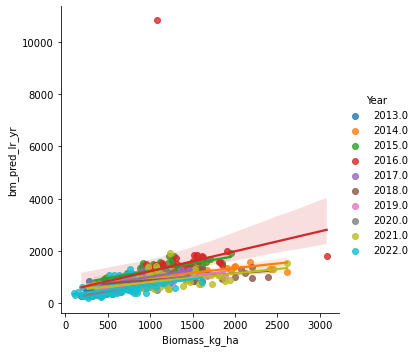

In [28]:
import seaborn as sns
sns.lmplot(df_vor_grp, x='Biomass_kg_ha', y='bm_pred_lr_yr', hue='Year')

In [29]:
df_vor_grp['Id_pasture'] = df_vor['Id_plot'].apply(lambda x: '_'.join(x.split('_')[0]))

In [30]:
df_vor_pasture = df_vor_grp.groupby(['Id_pasture', 'Date']).mean().reset_index()

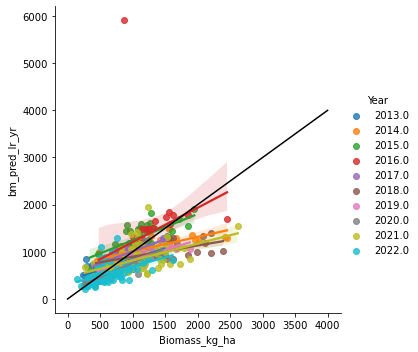

In [31]:
import seaborn as sns
p = sns.lmplot(df_vor_pasture, x='Biomass_kg_ha', y='bm_pred_lr_yr', hue='Year')
p.axes[0, 0].plot(np.arange(0, 4000), np.arange(0, 4000), c='black')

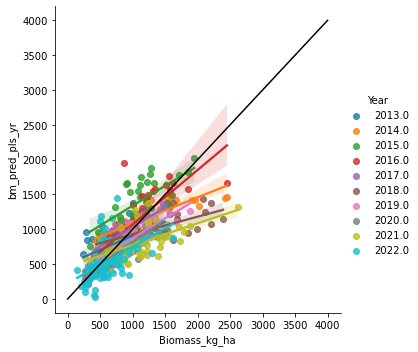

In [32]:
p2 = sns.lmplot(df_vor_pasture, x='Biomass_kg_ha', y='bm_pred_pls_yr', hue='Year')
p2.axes[0, 0].plot(np.arange(0, 4000), np.arange(0, 4000), c='black')